In [ ]:
!pip install -U gdown
!pip install torchmetrics
!rm -rf *
!gdown 1bUXPEVKrOho2DE54bI43aJdHgAWtjTj3
!gdown 1pu1b0kk3l4e0J0kma7G24dIHmySs6Y8o
!gdown 1xwMpWGAFCqpAdHh0Zf0RNE_4qk9UzV1M
!gdown 13Iyzc9lAdK2iOsZ4hkSwb1G95h08IhiB
!gdown 1P4E6cTn4X6rgK9SyOsMA344kLNyISPHQ
!unzip Phase1.zip

In [47]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm

In [12]:
in_channels = 1

In [13]:
class DenoisingAutoEncoder(torch.nn.Module):
    def __init__(self, in_channels):
        super(DenoisingAutoEncoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(2, 2), stride=(2, 2)),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(2, 2), stride=(2, 2)),

            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(2, 2), stride=(2, 2)),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(2, 2), stride=(2, 2)),

            torch.nn.Conv2d(in_channels=128, out_channels=in_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
noise_classifier = torchvision.models.efficientnet_v2_l(pretrained=True)
for param in noise_classifier.parameters():
    param.requires_grad = False
noise_classifier.avgpool = torch.nn.Identity()
noise_classifier.classifier[1] = torch.nn.Linear(in_features=327680, out_features=3, bias=True)
noise_classifier.to(device)
noise_classifier_optimizer = torch.optim.Adam(params=noise_classifier.parameters())

checkpoint = torch.load('noise_classifier.pth.tar', map_location=device)
noise_classifier.load_state_dict(checkpoint['state_dict'])
noise_classifier_optimizer.load_state_dict(checkpoint['optimizer'])
noise_classifier.eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:03<00:00, 139MB/s]  


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
gaussian_denoiser = DenoisingAutoEncoder(in_channels=in_channels).to(device)
gaussian_denoiser_optimizer = torch.optim.Adam(params=gaussian_denoiser.parameters())

checkpoint = torch.load('gaussian_denoiser.pth.tar', map_location=device)
gaussian_denoiser.load_state_dict(checkpoint['state_dict'])
gaussian_denoiser_optimizer.load_state_dict(checkpoint['optimizer'])
gaussian_denoiser.eval()

DenoisingAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, 

In [17]:
periodic_denoiser = DenoisingAutoEncoder(in_channels=in_channels).to(device)
periodic_denoiser_optimizer = torch.optim.Adam(params=periodic_denoiser.parameters())

checkpoint = torch.load('periodic_denoiser.pth.tar', map_location=device)
periodic_denoiser.load_state_dict(checkpoint['state_dict'])
periodic_denoiser_optimizer.load_state_dict(checkpoint['optimizer'])
periodic_denoiser.eval()

DenoisingAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, 

In [18]:
salt_denoiser = DenoisingAutoEncoder(in_channels=in_channels).to(device)
salt_denoiser_optimizer = torch.optim.Adam(params=salt_denoiser.parameters())

checkpoint = torch.load('salt_denoiser.pth.tar', map_location=device)
salt_denoiser.load_state_dict(checkpoint['state_dict'])
salt_denoiser_optimizer.load_state_dict(checkpoint['optimizer'])
salt_denoiser.eval()

DenoisingAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, 

In [40]:
os.mkdir('DataSet1_Noise_Removed')
os.mkdir(os.path.join('DataSet1_Noise_Removed', 'Defected'))
os.mkdir(os.path.join('DataSet1_Noise_Removed', 'OK'))
with torch.no_grad():
    for image_name in os.listdir(os.path.join('DataSet1', 'Defected')):
        noisy_image_gray = torch.from_numpy(cv2.imread(os.path.join('DataSet1', 'Defected', image_name), flags=cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255).unsqueeze(0).unsqueeze(0).to(device)
        noisy_image_rgb = torch.from_numpy(cv2.imread(os.path.join('DataSet1', 'Defected', image_name), flags=cv2.IMREAD_COLOR).astype(np.float32) / 255).permute((2, 0, 1)).unsqueeze(0).to(device)
        scores = noise_classifier(noisy_image_rgb)
        predictions = scores.max(1)[1]
        if predictions[0] == 0: # Gaussian
            output = gaussian_denoiser(noisy_image_gray).squeeze(0).squeeze(0)
        elif predictions[0] == 1: # Periodic
            output = periodic_denoiser(noisy_image_gray).squeeze(0).squeeze(0)
        else: # Salt
            output = salt_denoiser(noisy_image_gray).squeeze(0).squeeze(0)

        cv2.imwrite(os.path.join('DataSet1_Noise_Removed', 'Defected', f"{image_name}"), cv2.cvtColor(cv2.normalize(src=output.detach().cpu().numpy(), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U), cv2.COLOR_GRAY2BGR))

    for image_name in os.listdir(os.path.join('DataSet1', 'OK')):
        noisy_image_gray = torch.from_numpy(cv2.imread(os.path.join('DataSet1', 'OK', image_name), flags=cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255).unsqueeze(0).unsqueeze(0).to(device)
        noisy_image_rgb = torch.from_numpy(cv2.imread(os.path.join('DataSet1', 'OK', image_name), flags=cv2.IMREAD_COLOR).astype(np.float32) / 255).permute((2, 0, 1)).unsqueeze(0).to(device)
        scores = noise_classifier(noisy_image_rgb)
        predictions = scores.max(1)[1]
        if predictions[0] == 0: # Gaussian
            output = gaussian_denoiser(noisy_image_gray).squeeze(0).squeeze(0)
        elif predictions[0] == 1: # Periodic
            output = periodic_denoiser(noisy_image_gray).squeeze(0).squeeze(0)
        else: # Salt
            output = salt_denoiser(noisy_image_gray).squeeze(0).squeeze(0)

        cv2.imwrite(os.path.join('DataSet1_Noise_Removed', 'OK', f"{image_name}"), cv2.cvtColor(cv2.normalize(src=output.detach().cpu().numpy(), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U), cv2.COLOR_GRAY2BGR))

In [48]:
in_channels = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 64
num_epochs = 10

In [54]:
torch.manual_seed(42)

In [49]:
def create_model():
    model = torchvision.models.efficientnet_v2_l(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = torch.nn.Identity()
    model.classifier = torch.nn.Linear(in_features=327680, out_features=1)
    model.to(device)
    return model

In [55]:
class DisksDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir='DataSet1_Noise_Removed', transform=None):
        defected_images_names = list(map(lambda x: os.path.join('Defected', x), os.listdir(os.path.join(root_dir, 'Defected'))))
        ok_images_names = list(map(lambda x: os.path.join('OK', x), os.listdir(os.path.join(root_dir, 'OK'))))
        self.annotations = pd.DataFrame({'img_name': defected_images_names + ok_images_names, 'label': [1]*len(defected_images_names) + [0]*len(ok_images_names)})
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = cv2.imread(filename=img_path, flags=cv2.IMREAD_COLOR)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        if self.transform:
            image = self.transform(image)
        return (image, y_label)

dataset = DisksDataset(transform=torchvision.transforms.ToTensor())
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [1000, 250])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [51]:
model = create_model()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [56]:
train_acc = []
validation_acc = []

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader, total=len(train_loader), leave=True)
    total_correct = 0
    total_samples = 0
    for data, targets in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data).reshape(-1)
        loss = criterion(scores, targets.float())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_correct += ((scores >= 0).float() == targets).sum().item()
        total_samples += scores.size(0)
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), train_acc=total_correct/total_samples)
    train_acc.append(total_correct/total_samples)

    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model(data).reshape(-1)
            total_correct += ((scores >= 0).float() == targets).sum().item()
            total_samples += scores.size(0)
        validation_acc.append(total_correct/total_samples)
        print(f"Validation Accuracy: {validation_acc[-1]}")

Epoch [1/10]: 100%|██████████| 16/16 [00:56<00:00,  3.50s/it, loss=0.456, train_acc=0.94] 


Validation Accuracy: 0.96


Epoch [2/10]: 100%|██████████| 16/16 [00:55<00:00,  3.46s/it, loss=0.114, train_acc=0.963]  


Validation Accuracy: 0.956


Epoch [3/10]: 100%|██████████| 16/16 [00:55<00:00,  3.48s/it, loss=0.362, train_acc=0.968] 


Validation Accuracy: 0.976


Epoch [4/10]: 100%|██████████| 16/16 [00:55<00:00,  3.47s/it, loss=9.09e-7, train_acc=0.984] 


Validation Accuracy: 0.972


Epoch [5/10]: 100%|██████████| 16/16 [00:55<00:00,  3.48s/it, loss=0.0854, train_acc=0.985] 


Validation Accuracy: 0.968


Epoch [6/10]: 100%|██████████| 16/16 [00:55<00:00,  3.48s/it, loss=0.126, train_acc=0.988]  


Validation Accuracy: 0.968


Epoch [7/10]: 100%|██████████| 16/16 [00:55<00:00,  3.47s/it, loss=0.0035, train_acc=0.983]  


Validation Accuracy: 0.964


Epoch [8/10]: 100%|██████████| 16/16 [00:55<00:00,  3.47s/it, loss=0.00907, train_acc=0.984]


Validation Accuracy: 0.972


Epoch [9/10]: 100%|██████████| 16/16 [00:55<00:00,  3.48s/it, loss=1.25e-7, train_acc=0.978]


Validation Accuracy: 0.984


Epoch [10/10]: 100%|██████████| 16/16 [00:55<00:00,  3.47s/it, loss=0.387, train_acc=0.978]  


Validation Accuracy: 0.964


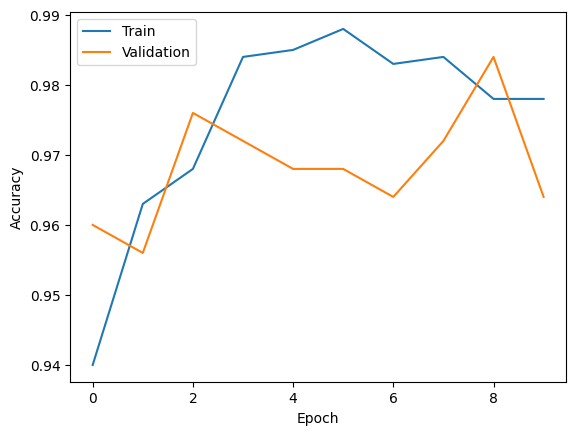

In [57]:
plt.plot(train_acc, label="Train")
plt.plot(validation_acc, label="Validation")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [58]:
from torchmetrics.functional.classification import binary_accuracy
from torchmetrics.functional.classification import binary_precision
from torchmetrics.functional.classification import binary_recall
from torchmetrics.functional.classification import binary_f1_score
from torchmetrics.functional.classification import binary_specificity
from torchmetrics.functional.classification import binary_auroc


def check_performance(loader, model):
    model.eval()
    full_y = torch.tensor([], device=device, dtype=torch.int8)
    full_predictions = torch.tensor([], device=device)
    full_scores = torch.tensor([], device=device)

    with torch.no_grad():
        for x, y in loader:

            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x).reshape(-1)
            predictions = (scores >= 0).float()
            full_y = torch.cat(tensors=(full_y, y))
            full_predictions = torch.cat(tensors=(full_predictions, predictions))
            full_scores = torch.cat(tensors=(full_scores, scores))
            

        accuracy = binary_accuracy(full_predictions, full_y)
        precision = binary_precision(full_predictions, full_y)
        recall = binary_recall(full_predictions, full_y)
        f1_score = binary_f1_score(full_predictions, full_y)
        specificity = binary_specificity(full_predictions, full_y)
        auroc = binary_auroc(full_scores, full_y)
    model.train()
    return accuracy, precision, recall, f1_score, specificity, auroc, full_y, full_predictions, full_scores

In [59]:
accuracy, precision, recall, f1_score, specificity, auroc, full_y, full_predictions, full_scores = check_performance(train_loader, model)
print(f"Accuracy: {accuracy:.4}\nPrecision: {precision:.4}\nRecall: {recall:.4}\nF1 score: {f1_score:.4}\nSpecificity: {specificity:.4}\nArea under the ROC: {auroc:.4}")

Accuracy: 0.999
Precision: 1.0
Recall: 0.9984
F1 score: 0.9992
Specificity: 1.0
Area under the ROC: 1.0


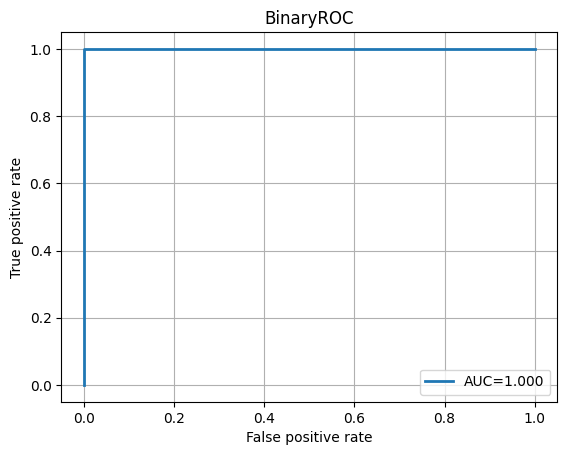

In [60]:
from torchmetrics.classification import BinaryROC
metric = BinaryROC()
metric.update(full_scores, full_y)
fig_, ax_ = metric.plot(score=True)

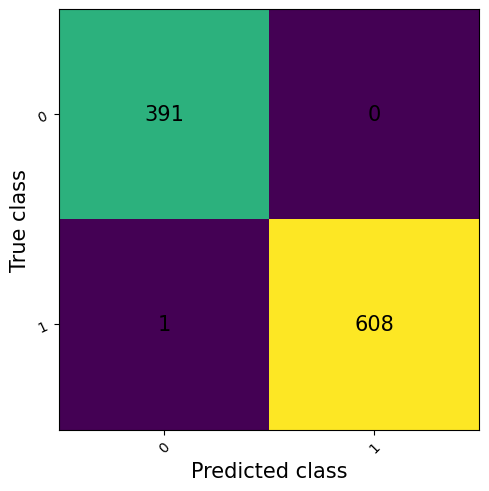

In [61]:
from torchmetrics.classification import BinaryConfusionMatrix
metric = BinaryConfusionMatrix().to(device)
metric.update(full_predictions, full_y)
fig_, ax_ = metric.plot()

In [62]:
accuracy, precision, recall, f1_score, specificity, auroc, full_y, full_predictions, full_scores = check_performance(test_loader, model)
print(f"Accuracy: {accuracy:.4}\nPrecision: {precision:.4}\nRecall: {recall:.4}\nF1 score: {f1_score:.4}\nSpecificity: {specificity:.4}\nArea under the ROC: {auroc:.4}")

Accuracy: 0.964
Precision: 1.0
Recall: 0.9362
F1 score: 0.967
Specificity: 1.0
Area under the ROC: 0.9973


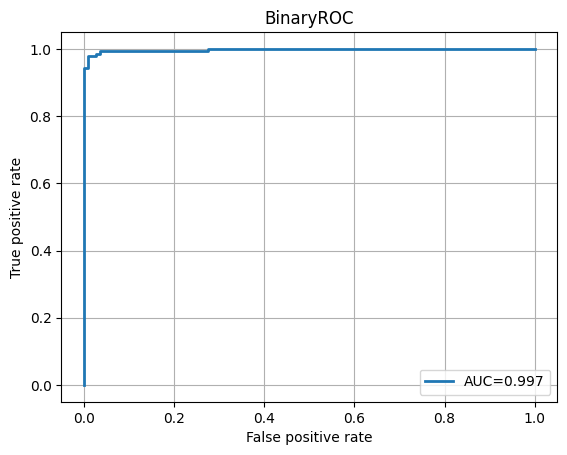

In [63]:
from torchmetrics.classification import BinaryROC
metric = BinaryROC()
metric.update(full_scores, full_y)
fig_, ax_ = metric.plot(score=True)

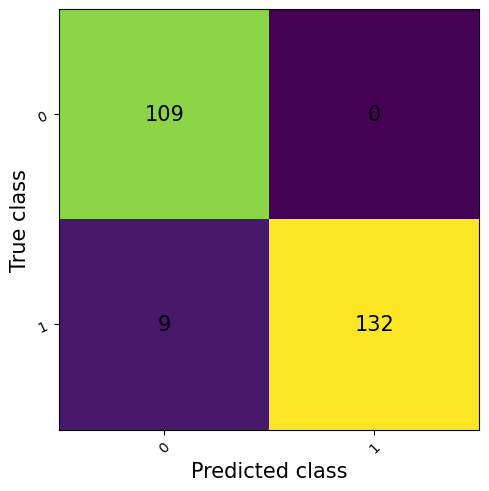

In [64]:
from torchmetrics.classification import BinaryConfusionMatrix
metric = BinaryConfusionMatrix().to(device)
metric.update(full_predictions, full_y)
fig_, ax_ = metric.plot()